In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from csbms import MultiClassCSBM
from CSBMFeat import CSBMFeat
from CSBMCl import CSBMCl
from metrics import mmd_linear, total_variation_distance

In [2]:
n = 200

In [3]:
def get_pairwise_mean_distance(csbm):
    means = csbm.means
    c = csbm.classes
    distance = 0
    count = 0
    for i in range(c):
        for j in range(c):
            if i == j:
                continue
            distance += np.linalg.norm(means[i] - means[j])
            count += 1
    return distance / count

In [4]:
def get_mean_initialiation_distance(csbm):
    means = csbm.means
    init = csbm.initial_means
    c = csbm.classes
    distance = 0
    for i in range(c):
            distance += np.linalg.norm(means[i] - init[i])
    return distance / c

In [5]:
def get_pairwise_neighbor_mean_distance(csbm):
    means = csbm.means
    c = csbm.classes
    distance = 0
    count = 0
    for i in range(c):
            distance += np.linalg.norm(means[i] - means[(i + 1) % c])
            count += 1
    return distance / count

In [6]:
def get_pairwise_non_neighbor_mean_distance(csbm):
    means = csbm.means
    c = csbm.classes
    distance = 0
    count = 0
    for i in range(c):
        for j in range(c):
            if i == j or abs(i - j) == 1 or abs(i - j) == c - 1:
                continue
            distance += np.linalg.norm(means[i] - means[j])
            count += 1
    return distance / count

In [7]:
def mmd_per_class_linear(csbm):
    result = 0
    X = csbm.X[:n]
    y_1 = csbm.y[:n]
    Z = csbm.X[-n:]
    y_2 = csbm.y[-n:]
    for c in range(csbm.classes):
        result += mmd_linear(X[y_1==c], Z[y_2==c])
    return result / csbm.classes

In [8]:
# initialize
time_steps = []
mean_distance_from_initialization = []
mean_pairwise_distance_all = []
mean_pairwise_distance_neighbors = []
mean_pairwise_distance_non_neighbors = []

mmd_linear_feat = []
mmd_linear_constant = []

mmd_rbf = []
mmd_rbf_constant = []

# simulate
csbm_feature = CSBMFeat(n=n)
csbm_constant = MultiClassCSBM(n=n)

for t in range(13):
    time_steps.append(t)

    mmd_linear_feat.append(mmd_per_class_linear(csbm_feature))
    mmd_linear_constant.append(mmd_per_class_linear(csbm_constant))

    mmd_rbf.append(csbm_feature.get_feature_shift_rbf_mmd())
    mmd_rbf_constant.append(csbm_constant.get_feature_shift_rbf_mmd())

    mean_pairwise_distance_all.append(get_pairwise_mean_distance(csbm_feature))
    mean_distance_from_initialization.append(get_mean_initialiation_distance(csbm_feature))
    mean_pairwise_distance_neighbors.append(get_pairwise_neighbor_mean_distance(csbm_feature))
    mean_pairwise_distance_non_neighbors.append(get_pairwise_non_neighbor_mean_distance(csbm_feature))

    csbm_feature.evolve()
    csbm_constant.evolve()

## Plot MMD for feature shift

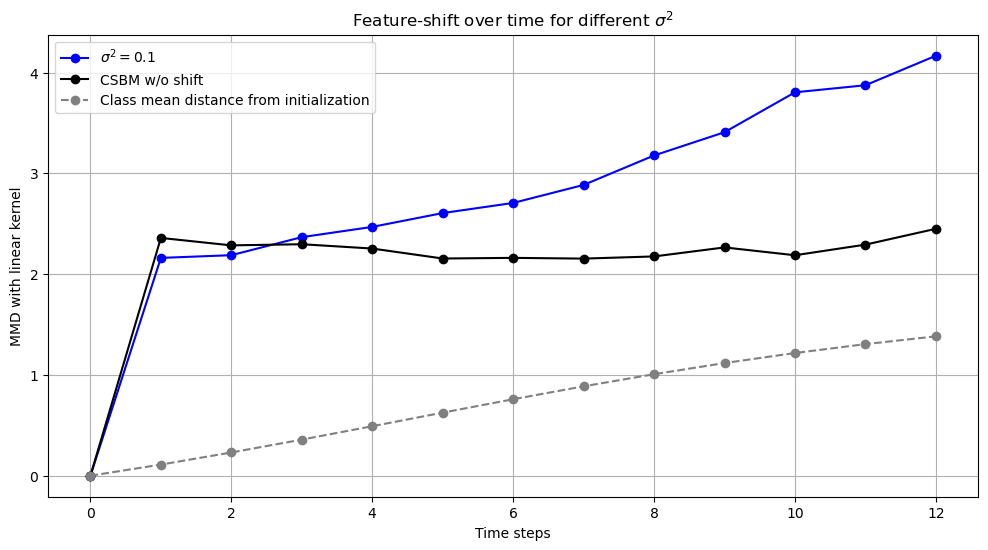

In [9]:
# linear kernel MMD
plt.figure(figsize=(12, 6))
plt.title(r'Feature-shift over time for different $\sigma^{2}$')

plt.plot(time_steps, mmd_linear_feat, marker='o', linestyle='-', color='b', label=r'$\sigma^{2}=0.1$')
plt.plot(time_steps, mmd_linear_constant, marker='o', linestyle='-', color='black', label='CSBM w/o shift')
plt.plot(time_steps, mean_distance_from_initialization, marker='o', linestyle='--', color='gray', label='Class mean distance from initialization')
plt.xlabel('Time steps')
plt.ylabel('MMD with linear kernel')
plt.grid(True)
plt.legend(loc='upper left')
#plt.savefig('feature_shift_linear.pdf', format='pdf')
plt.show()
plt.close()

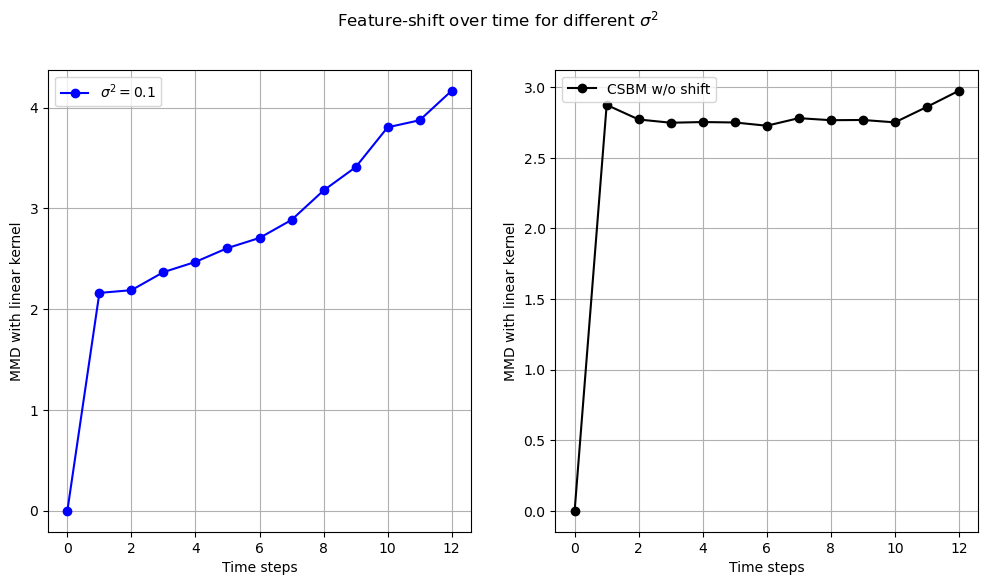

In [10]:
## separate
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle(r'Feature-shift over time for different $\sigma^{2}$')

axes[0].plot(time_steps, mmd_linear_feat, marker='o', linestyle='-', color='b', label=r'$\sigma^{2}=0.1$')
axes[0].grid(True)
axes[1].plot(time_steps, mmd_rbf_constant, marker='o', linestyle='-', color='black', label='CSBM w/o shift')
axes[1].grid(True)
for ax in axes:
    ax.set_xlabel('Time steps')
    ax.set_ylabel('MMD with linear kernel')
    ax.legend(loc='upper left')
#plt.savefig('feature_shift_linear_separate.pdf', format='pdf')
plt.show()
plt.close()

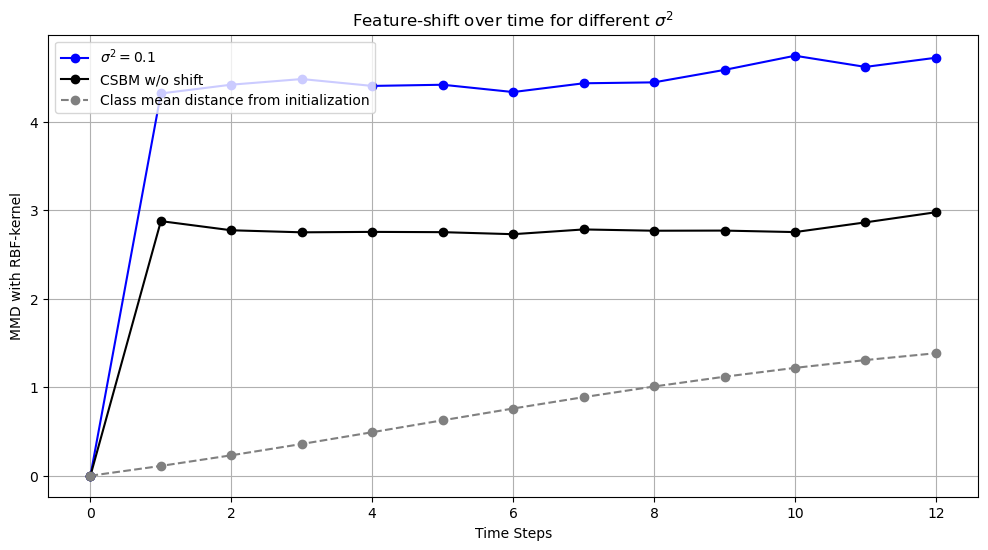

In [11]:
# RBF kernel MMD
plt.figure(figsize=(12, 6))
plt.title(r'Feature-shift over time for different $\sigma^{2}$')

plt.plot(time_steps, mmd_rbf, marker='o', linestyle='-', color='b', label=r'$\sigma^{2}=0.1$')
plt.plot(time_steps, mmd_rbf_constant, marker='o', linestyle='-', color='black', label='CSBM w/o shift')
plt.plot(time_steps, mean_distance_from_initialization, marker='o', linestyle='--', color='gray', label='Class mean distance from initialization')
plt.xlabel('Time Steps')
plt.ylabel('MMD with RBF-kernel')
plt.grid(True)
plt.legend(loc='upper left')
#plt.savefig('feature_shift_rbf.pdf', format='pdf')
plt.show()
plt.close()

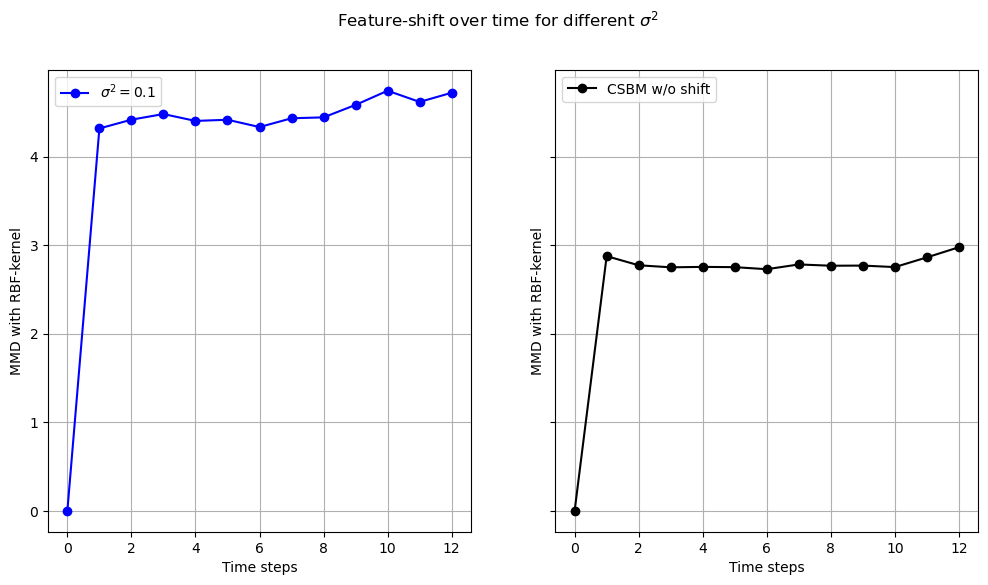

In [12]:
## separate
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle(r'Feature-shift over time for different $\sigma^{2}$')

axes[0].plot(time_steps, mmd_rbf, marker='o', linestyle='-', color='b', label=r'$\sigma^{2}=0.1$')
axes[0].grid(True)
axes[1].plot(time_steps, mmd_rbf_constant, marker='o', linestyle='-', color='black', label='CSBM w/o shift')
axes[1].grid(True)
for ax in axes:
    ax.set_xlabel('Time steps')
    ax.set_ylabel('MMD with RBF-kernel')
    ax.legend(loc='upper left')
#plt.savefig('feature_shift_rbf_separate.pdf', format='pdf')
plt.show()
plt.close()

## Plot relations of class means

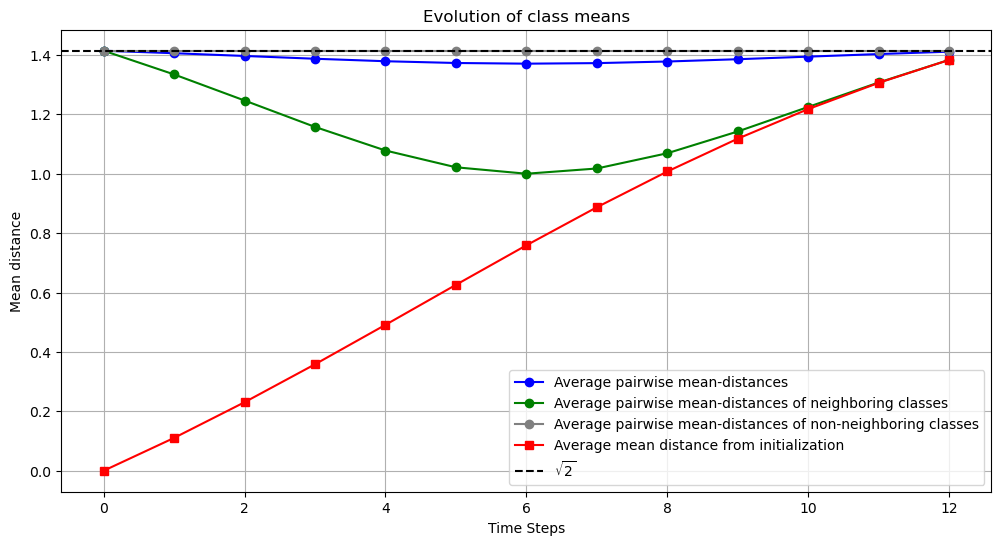

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mean_pairwise_distance_all, marker='o', linestyle='-', color='b', label='Average pairwise mean-distances')
plt.plot(time_steps, mean_pairwise_distance_neighbors, marker='o', linestyle='-', color='green', label='Average pairwise mean-distances of neighboring classes')
plt.plot(time_steps, mean_pairwise_distance_non_neighbors, marker='o', linestyle='-', color='gray', label='Average pairwise mean-distances of non-neighboring classes')
plt.plot(time_steps, mean_distance_from_initialization, marker='s', linestyle='-', color='r', label='Average mean distance from initialization')
plt.axhline(y=math.sqrt(2), color='black', linestyle='--', label=r'$\sqrt{2}$')

plt.title('Evolution of class means')
plt.xlabel('Time Steps')
plt.ylabel('Mean distance')
plt.grid(True)
plt.legend(loc='lower right')
#plt.savefig('class_means.pdf', format='pdf')
plt.show()
plt.close()

## Plot class label distribution shift

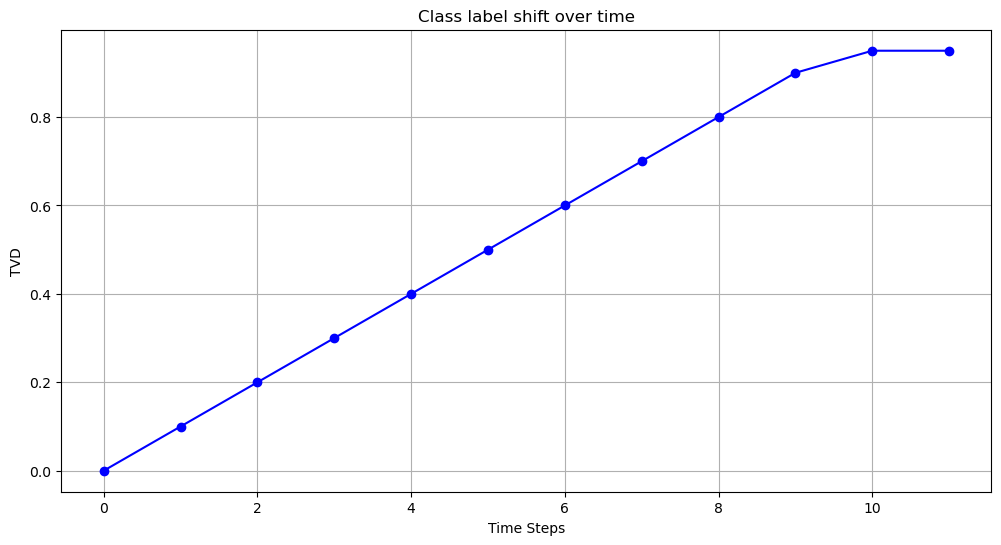

In [15]:
time_steps = []
tvs = []
csbm = CSBMCl(n=n)
initial_distribution = csbm.p
for t in range(12):
    time_steps.append(t)
    tvs.append(total_variation_distance(initial_distribution, csbm.p))
    csbm.evolve()

plt.figure(figsize=(12, 6))
plt.title('Class label shift over time')
plt.plot(time_steps, tvs, marker='o', linestyle='-', color='b')
plt.xlabel('Time Steps')
plt.ylabel('TVD')
plt.grid(True)
#plt.savefig('class_label_shift.pdf', format='pdf')
plt.show()
plt.close()